In [1]:
import ochre_gym

print("--- DIAGNOSTIC START ---")

env = ochre_gym.load(
    "bldg0112631-up11",
    override_equipment_controls={"HVAC Heating": ["Setpoint"]},
    vectorize_actions=True,
    vectorize_observations=False,
    
    start_time="2018-01-01 00:00:00",
    episode_duration="1 days",
    time_res="00:30",
    lookahead="12:00",            
    
    dr_type="TOU",
    dr_subfolder="basic-v0",
    tou_price_file="time_of_use_price.csv"
)

obs, info = env.reset()

print("\n=== FULL OBSERVATION KEY LIST (with sample values) ===")
for i, (k, v) in enumerate(sorted(obs.items())):
    print(f"{i+1:02d}: {k:40s} -> {v}")
print("======================================================")

env.close()


Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw


--- DIAGNOSTIC START ---


Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.



=== FULL OBSERVATION KEY LIST (with sample values) ===
01: Air Changes per Hour - Indoor (1/hour)   -> 0.6612424032068087
02: Air Density - Indoor (kg/m^3)            -> 0.9699131934754261
03: Day of month                             -> 1
04: Day of week                              -> 0
05: Energy Price ($)                         -> 1
06: Forced Ventilation Flow Rate - Indoor (m^3/s) -> 0.0
07: Forced Ventilation Heat Gain - Indoor (W) -> -0.0
08: Grid Voltage (-)                         -> 1
09: HVAC Heating Electric Power (kW)         -> 2.5008991643346494
10: HVAC Heating Reactive Power (kVAR)       -> 1.6154212749561736
11: Hour of day                              -> 0
12: Humidity Ratio - Indoor (-)              -> 0.001859551898027607
13: Infiltration Flow Rate - Attic (m^3/s)   -> 0.25696523762085094
14: Infiltration Flow Rate - Foundation (m^3/s) -> 0.2924449115766115
15: Infiltration Flow Rate - Garage (m^3/s)  -> 0.3805784181964799
16: Infiltration Flow Rate - Indoor (m^3/

In [2]:
import gymnasium as gym
import numpy as np
import ochre_gym

# -------------------------------------------------------------
# Environment configuration
# -------------------------------------------------------------

ENV_NAME = "bldg0112631-up11"

# Base observation keys (current values only)
BASE_OBS_KEYS = [
    "Temperature - Indoor (C)",
    "Temperature - Outdoor (C)",
    "Energy Price ($)",
    "Hour of day",
]

def build_obs_keys_with_forecast():
    """
    Build OBS_KEYS.

    Note:
    OCHRE vectorizes observations in alphabetical order of the keys.
    We therefore sort BASE_OBS_KEYS here so that the positions in the
    vectorized obs match the indices we derive below. Future temperature
    and price features (next 12 hours) will be appended via a separate
    wrapper, not via OCHRE's built-in observation keys.
    """
    return sorted(BASE_OBS_KEYS)

# Observation keys selected from the OCHRE environment
OBS_KEYS = build_obs_keys_with_forecast()

# Indices for vectorized observations (alphabetical order matching OCHRE)
INDOOR_TEMP_IDX  = OBS_KEYS.index("Temperature - Indoor (C)")
OUTDOOR_TEMP_IDX = OBS_KEYS.index("Temperature - Outdoor (C)")
PRICE_IDX        = OBS_KEYS.index("Energy Price ($)")
HOUR_IDX         = OBS_KEYS.index("Hour of day")


def make_env(start_time: str, episode_duration: str):
    """
    Helper to create an OCHRE environment for a given start time and duration.
    The environment exposes a continuous heating setpoint action for SAC.
    """
    base_env = ochre_gym.load(
        ENV_NAME,
        override_equipment_controls={"HVAC Heating": ["Setpoint"]},
        vectorize_actions=True,
        vectorize_observations=True,
        override_ochre_observations_with_keys=OBS_KEYS,

        # Episode settings
        start_time=start_time,
        episode_duration=episode_duration,
        time_res="00:30",
        lookahead="12:00",  # still use 12h lookahead internally

        # Demand response configuration
        dr_type="TOU",
        dr_subfolder="basic-v0",
        tou_price_file="time_of_use_price.csv",

        # Comfort constraints and reward scaling
        thermal_comfort_band_low=20,
        thermal_comfort_band_high=23,
        thermal_comfort_unit_penalty=0.0,
        reward_scale=0.1,

        # Logging options
        log_to_file=False,
        log_to_console=False,
    )
    return base_env


In [3]:
# -------------------------------------------------------------
# Varying thermal comfort band
# -------------------------------------------------------------

def get_comfort_band(hour_of_day: float):
    """
    Returns (low, high) comfort band in °C based on the hour of day.

    - 19–23 °C for h in [18:00, 24:00) U [00:00, 09:00]
      (i.e., includes exactly 09:00 and 18:00)
    - 17–26 °C for h in (09:00, 18:00)
    """
    # Make sure hour is in [0, 24)
    h = float(hour_of_day) % 24.0

    # Night / early morning / boundary hours
    if (h >= 18.0) or (h <= 9.0):
        return 19.0, 23.0
    # Daytime
    else:
        return 17.0, 26.0


In [4]:
import pandas as pd  # add this at top of the cell if not already imported

# -------------------------------------------------------------
# Wrapper to apply varying thermal comfort band to the reward
# -------------------------------------------------------------
class VariableComfortRewardWrapper(gym.Wrapper):
    def __init__(
        self,
        env,
        comfort_unit_penalty: float = 0.0,
        reward_scale: float = 0.1,
    ):
        """
        env: base OCHRE env with thermal_comfort_unit_penalty=0.0 in its config
        comfort_unit_penalty: penalty per °C deviation from comfort band
        reward_scale: same scale factor used in the base env
        """
        super().__init__(env)
        self.comfort_unit_penalty = comfort_unit_penalty
        self.reward_scale = reward_scale

    def reset(self, **kwargs):
        """Just reset the underlying env."""
        return self.env.reset(**kwargs)

    def _hour_from_info(self, info) -> float:
        """
        Compute hour-of-day directly from info['Datetime'] if available.
        Falls back to 0.0 if not present (should not happen for OCHRE).
        """
        if isinstance(info, dict) and ("Datetime" in info):
            dt = info["Datetime"]
            if not isinstance(dt, pd.Timestamp):
                dt = pd.to_datetime(dt)
            return dt.hour + dt.minute / 60.0
        # Fallback: harmless default
        return 0.0

    def step(self, action):
        # Gymnasium-style step: returns obs, reward, terminated, truncated, info
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Hour-of-day from Datetime (no more step-counter offset)
        hour_of_day = self._hour_from_info(info)

        # Get varying comfort band based on hour
        comfort_low, comfort_high = get_comfort_band(hour_of_day)

        # Indoor temperature: use info dict (reliable), fall back to obs if needed
        if isinstance(info, dict) and ("Temperature - Indoor (C)" in info):
            indoor_temp = float(info["Temperature - Indoor (C)"])
        else:
            obs_arr = np.asarray(obs).ravel()
            indoor_temp = float(obs_arr[INDOOR_TEMP_IDX]) if obs_arr.size > INDOOR_TEMP_IDX else np.nan

        # Compute comfort violation (°C outside the band)
        if indoor_temp < comfort_low:
            comfort_violation = comfort_low - indoor_temp
        elif indoor_temp > comfort_high:
            comfort_violation = indoor_temp - comfort_high
        else:
            comfort_violation = 0.0

        # Our custom comfort penalty term, scaled similarly to original env
        comfort_penalty_term = self.reward_scale * self.comfort_unit_penalty * comfort_violation

        # Base env reward currently reflects (scaled) energy/cost only,
        # because we set thermal_comfort_unit_penalty=0.0 in make_env.
        new_reward = reward - comfort_penalty_term

        # Optional logging in info (can help debugging)
        info = dict(info)
        info["hour_used_for_band"] = hour_of_day
        info["comfort_low"] = comfort_low
        info["comfort_high"] = comfort_high
        info["comfort_violation"] = comfort_violation
        info["original_reward"] = reward
        info["custom_reward"] = new_reward

        return obs, new_reward, terminated, truncated, info


In [5]:
import numpy as np
import pandas as pd
import ochre_gym
import gymnasium as gym

# -------------------------------------------------------------
# Wrapper to append 12-hour forecasts (T_out, price) to obs
# -------------------------------------------------------------
class ForecastObsWrapper(gym.Wrapper):
    def __init__(
        self,
        env,
        start_time: str,
        episode_duration: str,
        horizon_hours: float = 12.0,
        time_res_minutes: int = 30,
    ):
        """
        Wraps an OCHRE env and augments the observation with future
        outdoor temperature and energy prices over a lookahead horizon.

        The base env exposes the 4 core obs defined in OBS_KEYS, which are
        vectorized in alphabetical order by OCHRE; semantics should always
        be accessed via the indices PRICE_IDX, HOUR_IDX, INDOOR_TEMP_IDX,
        and OUTDOOR_TEMP_IDX rather than assuming a fixed position.

        This wrapper appends:
        [T_out(t+1), ..., T_out(t+H),
         price(t+1), ..., price(t+H)]
        where H = horizon_hours / time_res_minutes * 60.
        """
        super().__init__(env)
        self.start_time = start_time
        self.episode_duration = episode_duration
        self.horizon_hours = horizon_hours
        self.time_res_minutes = time_res_minutes
        self.horizon_steps = int(horizon_hours * 60 / time_res_minutes)

        # Internal step counter within the episode
        self._current_step = 0

        # Precompute outdoor temperature and price for this episode window
        self._build_forecast_index()

        # Extend observation space: original dims + 2 * horizon_steps
        orig_space = env.observation_space
        orig_low = np.asarray(orig_space.low, dtype=np.float32).ravel()
        orig_high = np.asarray(orig_space.high, dtype=np.float32).ravel()

        extra_dim = 2 * self.horizon_steps  # future temps + future prices
        extra_low = np.full(extra_dim, -np.inf, dtype=np.float32)
        extra_high = np.full(extra_dim, np.inf, dtype=np.float32)

        self.observation_space = gym.spaces.Box(
            low=np.concatenate([orig_low, extra_low]),
            high=np.concatenate([orig_high, extra_high]),
            dtype=np.float32,
        )

    def _build_forecast_index(self):
        """
        Build a mapping from step index -> {T_out, price} for the whole
        episode window by running a temporary OCHRE env once.
        """
        tmp_env = ochre_gym.load(
            ENV_NAME,
            override_equipment_controls={"HVAC Heating": ["Setpoint"]},
            vectorize_actions=True,
            vectorize_observations=True,
            override_ochre_observations_with_keys=OBS_KEYS,

            start_time=self.start_time,
            episode_duration=self.episode_duration,
            time_res="00:30",
            lookahead="12:00",

            dr_type="TOU",
            dr_subfolder="basic-v0",
            tou_price_file="time_of_use_price.csv",

            thermal_comfort_band_low=20,
            thermal_comfort_band_high=23,
            thermal_comfort_unit_penalty=0.0,
            reward_scale=0.1,

            log_to_file=False,
            log_to_console=False,
        )

        obs, info = tmp_env.reset()
        self._forecast_data = {}
        step_idx = 0

        while True:
            obs_vec = np.asarray(obs).ravel()

            # Prefer info keys; fall back to obs vector if needed
            if isinstance(info, dict) and ("Temperature - Outdoor (C)" in info):
                t_out = info["Temperature - Outdoor (C)"]
            else:
                t_out = obs_vec[OUTDOOR_TEMP_IDX]

            if isinstance(info, dict) and ("Energy Price ($)" in info):
                price = info["Energy Price ($)"]
            else:
                price = obs_vec[PRICE_IDX]

            self._forecast_data[step_idx] = {
                "Temperature - Outdoor (C)": float(t_out),
                "Energy Price ($)": float(price),
            }

            # Any reasonable fixed action is fine; T_out and price don't depend on action
            action = np.array([21.0], dtype=np.float32)
            obs, r, terminated, truncated, info = tmp_env.step(action)
            step_idx += 1
            if terminated or truncated:
                break

        tmp_env.close()
        self._episode_length = step_idx  # total number of steps in the episode

    def _augment_observation(self, obs, step_idx, info):
        """
        Concatenate current obs with future T_out and price over the horizon.
        """
        obs_vec = np.asarray(obs).ravel()

        future_temps = []
        future_prices = []

        for k in range(1, self.horizon_steps + 1):
            idx = step_idx + k
            if idx >= self._episode_length:
                # Beyond last step: repeat last known values
                last = self._forecast_data[self._episode_length - 1]
                temp_k = last["Temperature - Outdoor (C)"]
                price_k = last["Energy Price ($)"]
            else:
                data_k = self._forecast_data[idx]
                temp_k = data_k["Temperature - Outdoor (C)"]
                price_k = data_k["Energy Price ($)"]

            future_temps.append(temp_k)
            future_prices.append(price_k)

        extra = np.asarray(future_temps + future_prices, dtype=obs_vec.dtype)
        return np.concatenate([obs_vec, extra], axis=0)

    def reset(self, **kwargs):
        self._current_step = 0
        obs, info = self.env.reset(**kwargs)
        obs_aug = self._augment_observation(obs, self._current_step, info)
        return obs_aug, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self._current_step += 1
        obs_aug = self._augment_observation(obs, self._current_step, info)
        return obs_aug, reward, terminated, truncated, info


In [6]:
import numpy as np
import pandas as pd

# -------------------------------------------------------------
# Sanity check: verify comfort band + key observations
# -------------------------------------------------------------
debug_env = VariableComfortRewardWrapper(
    make_env("2018-02-01 00:00:00", "1 days"),
    comfort_unit_penalty=0.0,
    reward_scale=0.1,
)

obs, info = debug_env.reset()
rows = []

# 48 steps = 24 hours at 30 min/step
for t in range(48):
    # Datetime from info if present, otherwise reconstruct from start time
    dt = info.get("Datetime", None)
    if dt is None:
        dt = pd.Timestamp("2018-02-01 00:00:00") + pd.Timedelta(minutes=30 * t)
    else:
        dt = pd.to_datetime(dt)

    # Hour-of-day from Datetime (always correct, no shift)
    hour_dt = dt.hour + dt.minute / 60.0
    band_low_dt, band_high_dt = get_comfort_band(hour_dt)

    # Flatten observation vector
    obs_arr = np.asarray(obs).ravel()

    row = {
        "step": t,
        "Datetime": dt,

        # Comfort band sanity (from Datetime)
        "hour_from_datetime": hour_dt,
        "comfort_low_dt": band_low_dt,
        "comfort_high_dt": band_high_dt,

        # What the wrapper logged (may be NaN on first row, but should match afterwards
        "hour_used_for_band": info.get("hour_used_for_band", np.nan),
        "comfort_low_info": info.get("comfort_low", np.nan),
        "comfort_high_info": info.get("comfort_high", np.nan),

        # Observations from info (trusted physical variables)
        "indoor_temp_info": info.get("Temperature - Indoor (C)", np.nan),
        "outdoor_temp_info": info.get("Temperature - Outdoor (C)", np.nan),
        "price_info": info.get("Energy Price ($)", np.nan),
        "hour_info": info.get("Hour of day", np.nan),

        # First 4 entries of the obs vector (for comparison)
        "obs_0": obs_arr[0] if obs_arr.size > 0 else np.nan,
        "obs_1": obs_arr[1] if obs_arr.size > 1 else np.nan,
        "obs_2": obs_arr[2] if obs_arr.size > 2 else np.nan,
        "obs_3": obs_arr[3] if obs_arr.size > 3 else np.nan,
    }
    rows.append(row)

    # Fixed action (e.g., 21°C setpoint) – only for advancing the env
    action = np.array([21.0], dtype=np.float32)
    obs, r, terminated, truncated, info = debug_env.step(action)
    if terminated or truncated:
        break

debug_df = pd.DataFrame(rows)

# 1) Comfort band vs. hour sanity (use hour_from_datetime + comfort_*_dt)
print(debug_df[[
    "step",
    "Datetime",
    "hour_from_datetime",
    "comfort_low_dt",
    "comfort_high_dt",
]])

day_mask = (debug_df["hour_from_datetime"] > 9.0) & (debug_df["hour_from_datetime"] < 18.0)

print("\nBands when hour in (9, 18):")
print(debug_df.loc[day_mask, ["comfort_low_dt", "comfort_high_dt"]].drop_duplicates())

print("\nBands when hour <= 9 or >= 18:")
print(debug_df.loc[~day_mask, ["comfort_low_dt", "comfort_high_dt"]].drop_duplicates())

# 2) Observation mapping sanity (info vs obs vector) – unchanged
print("\nFirst 20 steps – compare info vs obs[0..3]:")
print(
    debug_df.loc[:52, [
        "step",
        "indoor_temp_info",
        "outdoor_temp_info",
        "price_info",
        "hour_info",
        "obs_0",
        "obs_1",
        "obs_2",
        "obs_3",
    ]]
)


Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


    step            Datetime  hour_from_datetime  comfort_low_dt  \
0      0 2018-02-01 00:00:00                 0.0            19.0   
1      1 2018-02-01 00:30:00                 0.5            19.0   
2      2 2018-02-01 01:00:00                 1.0            19.0   
3      3 2018-02-01 01:30:00                 1.5            19.0   
4      4 2018-02-01 02:00:00                 2.0            19.0   
5      5 2018-02-01 02:30:00                 2.5            19.0   
6      6 2018-02-01 03:00:00                 3.0            19.0   
7      7 2018-02-01 03:30:00                 3.5            19.0   
8      8 2018-02-01 04:00:00                 4.0            19.0   
9      9 2018-02-01 04:30:00                 4.5            19.0   
10    10 2018-02-01 05:00:00                 5.0            19.0   
11    11 2018-02-01 05:30:00                 5.5            19.0   
12    12 2018-02-01 06:00:00                 6.0            19.0   
13    13 2018-02-01 06:30:00                 6.5

In [7]:
import numpy as np
import pandas as pd

# -------------------------------------------------------------
# Inspect base observation vector over time (no forecasts)
# -------------------------------------------------------------
inspect_env = make_env("2018-02-01 00:00:00", "1 days")

obs, info = inspect_env.reset()
rows = []

# 48 steps = 24 hours at 30 min/step
for t in range(48):
    # Datetime from info if present, otherwise reconstruct from start time
    dt = info.get("Datetime", None)
    if dt is None:
        dt = pd.Timestamp("2018-02-01 00:00:00") + pd.Timedelta(minutes=30 * t)
    else:
        dt = pd.to_datetime(dt)

    obs_arr = np.asarray(obs).ravel()

    row = {
        "step": t,
        "Datetime": dt,
    }

    # Map each entry in OBS_KEYS to its value in the vectorized obs
    for i, key in enumerate(OBS_KEYS):
        row[key] = obs_arr[i] if i < obs_arr.size else np.nan

    rows.append(row)

    # Fixed action just to advance the environment (e.g., 21°C setpoint)
    action = np.array([21.0], dtype=np.float32)
    obs, r, terminated, truncated, info = inspect_env.step(action)
    if terminated or truncated:
        break

inspect_env.close()

obs_time_df = pd.DataFrame(rows)

# Show a subset; you can change columns or use .head() as needed
print(obs_time_df.head(20))


Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


    step            Datetime  Energy Price ($)  Hour of day  \
0      0 2018-02-01 00:00:00               1.0          0.0   
1      1 2018-02-01 00:30:00               1.0          0.0   
2      2 2018-02-01 01:00:00               1.0          0.0   
3      3 2018-02-01 01:30:00               1.0          1.0   
4      4 2018-02-01 02:00:00               1.0          1.0   
5      5 2018-02-01 02:30:00               1.0          2.0   
6      6 2018-02-01 03:00:00               1.0          2.0   
7      7 2018-02-01 03:30:00               1.0          3.0   
8      8 2018-02-01 04:00:00               1.0          3.0   
9      9 2018-02-01 04:30:00               1.0          4.0   
10    10 2018-02-01 05:00:00               1.0          4.0   
11    11 2018-02-01 05:30:00               1.0          5.0   
12    12 2018-02-01 06:00:00               1.0          5.0   
13    13 2018-02-01 06:30:00               1.0          6.0   
14    14 2018-02-01 07:00:00               1.0         

In [8]:
print(
    debug_df.loc[:30, [
        "step",
        "Datetime",
        "hour_from_datetime",
        "obs_1",
    ]]
)


    step            Datetime  hour_from_datetime  obs_1
0      0 2018-02-01 00:00:00                 0.0    0.0
1      1 2018-02-01 00:30:00                 0.5    0.0
2      2 2018-02-01 01:00:00                 1.0    0.0
3      3 2018-02-01 01:30:00                 1.5    1.0
4      4 2018-02-01 02:00:00                 2.0    1.0
5      5 2018-02-01 02:30:00                 2.5    2.0
6      6 2018-02-01 03:00:00                 3.0    2.0
7      7 2018-02-01 03:30:00                 3.5    3.0
8      8 2018-02-01 04:00:00                 4.0    3.0
9      9 2018-02-01 04:30:00                 4.5    4.0
10    10 2018-02-01 05:00:00                 5.0    4.0
11    11 2018-02-01 05:30:00                 5.5    5.0
12    12 2018-02-01 06:00:00                 6.0    5.0
13    13 2018-02-01 06:30:00                 6.5    6.0
14    14 2018-02-01 07:00:00                 7.0    6.0
15    15 2018-02-01 07:30:00                 7.5    7.0
16    16 2018-02-01 08:00:00                 8.0

In [9]:
import numpy as np
import pandas as pd

# -------------------------------------------------------------
# Full augmented observation table (all 52 features)
# -------------------------------------------------------------
HORIZON_HOURS = 12.0
TIME_RES_MIN = 30
H = int(HORIZON_HOURS * 60 / TIME_RES_MIN)   # 12h / 30min = 24 steps
BASE_DIM = len(OBS_KEYS)                     # 4 base obs

EXTRA_TEMP_START = BASE_DIM                  # T_out(t+1..t+H)
EXTRA_PRICE_START = BASE_DIM + H             # price(t+1..t+H)

# Build wrapped env: base -> comfort reward -> forecast obs
full_env = ForecastObsWrapper(
    VariableComfortRewardWrapper(
        make_env("2018-02-01 00:00:00", "1 days"),
        comfort_unit_penalty=0.0,
        reward_scale=0.1,
    ),
    start_time="2018-02-01 00:00:00",
    episode_duration="1 days",
    horizon_hours=HORIZON_HOURS,
    time_res_minutes=TIME_RES_MIN,
)

obs, info = full_env.reset()
rows = []

start_ts = pd.Timestamp("2018-02-01 00:00:00")

# 48 steps = 24 hours at 30 min/step
for t in range(48):
    dt = start_ts + pd.Timedelta(minutes=TIME_RES_MIN * t)
    obs_arr = np.asarray(obs).ravel()

    row = {
        "step": t,
        "Datetime": dt,
        "obs_dim": obs_arr.size,
        # base obs via semantic indices
        "price_now":  obs_arr[PRICE_IDX],
        "hour_now":   obs_arr[HOUR_IDX],
        "T_in_now":   obs_arr[INDOOR_TEMP_IDX],
        "T_out_now":  obs_arr[OUTDOOR_TEMP_IDX],
    }

    # All future outdoor temperatures
    for k in range(1, H + 1):
        row[f"T_out+{k}"] = obs_arr[EXTRA_TEMP_START + k - 1]

    # All future prices
    for k in range(1, H + 1):
        row[f"price+{k}"] = obs_arr[EXTRA_PRICE_START + k - 1]

    rows.append(row)

    action = np.array([21.0], dtype=np.float32)  # fixed setpoint just to advance
    obs, r, terminated, truncated, info = full_env.step(action)
    if terminated or truncated:
        break

full_env.close()

full_obs_df = pd.DataFrame(rows)

print("Columns (total):", len(full_obs_df.columns))
print(full_obs_df.head(50))


Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.
Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


Columns (total): 55
    step            Datetime  obs_dim  price_now  hour_now   T_in_now  \
0      0 2018-02-01 00:00:00       52        1.0       0.0  20.707196   
1      1 2018-02-01 00:30:00       52        1.0       0.0  21.078022   
2      2 2018-02-01 01:00:00       52        1.0       0.0  21.089720   
3      3 2018-02-01 01:30:00       52        1.0       1.0  21.093600   
4      4 2018-02-01 02:00:00       52        1.0       1.0  21.094906   
5      5 2018-02-01 02:30:00       52        1.0       2.0  21.094969   
6      6 2018-02-01 03:00:00       52        1.0       2.0  21.095151   
7      7 2018-02-01 03:30:00       52        1.0       3.0  21.094897   
8      8 2018-02-01 04:00:00       52        1.0       3.0  21.094974   
9      9 2018-02-01 04:30:00       52        1.0       4.0  21.094684   
10    10 2018-02-01 05:00:00       52        1.0       4.0  21.094751   
11    11 2018-02-01 05:30:00       52        1.0       5.0  21.094421   
12    12 2018-02-01 06:00:00   

In [15]:
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# Monitor-wrapped training env (7-day episode starting Jan 1)
#   Stack: OCHRE -> ComfortReward -> ForecastObs -> Monitor
# -------------------------------------------------------------
def make_train_env():
    start_time = "2018-01-01 00:00:00"
    episode_duration = "31 days"

    base = make_env(start_time, episode_duration)

    # Apply the varying comfort-band reward wrapper
    base = VariableComfortRewardWrapper(
        base,
        comfort_unit_penalty=1.0,  # same as original env setting
        reward_scale=0.1,          # matches make_env reward_scale
    )

    # Append 12-hour forecasts of T_out and price to the observation
    base = ForecastObsWrapper(
        base,
        start_time=start_time,
        episode_duration=episode_duration,
        horizon_hours=12.0,
        time_res_minutes=30,
    )

    return Monitor(base)

train_env = DummyVecEnv([make_train_env])


# -------------------------------------------------------------
# Callback to record episode returns during training
# -------------------------------------------------------------
class EpisodeRewardCallback(BaseCallback):
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.ep_returns: list[float] = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        for info in infos:
            if "episode" in info:
                # total reward for that finished episode
                self.ep_returns.append(info["episode"]["r"])
        return True


# -------------------------------------------------------------
# SAC model definition
# -------------------------------------------------------------
sac_model = SAC(
    "MlpPolicy",
    train_env,
    verbose=2,
    learning_rate=3e-4,
    gamma=0.99,
    buffer_size=50_000,
    batch_size=256,
    tau=0.005,
    train_freq=1,
    gradient_steps=1,
    ent_coef="auto",
)

# -------------------------------------------------------------
# Train SAC and log episode returns
# -------------------------------------------------------------
callback = EpisodeRewardCallback()

sac_model.learn(
    total_timesteps=150_000,
    log_interval=5,
    callback=callback,
)

ep_returns_sac = np.asarray(callback.ep_returns, dtype=float)
print(f"Recorded {len(ep_returns_sac)} finished episodes.")


Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.
Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.49e+03 |
|    ep_rew_mean     | -672     |
| time/              |          |
|    episodes        | 5        |
|    fps             | 34       |
|    time_elapsed    | 213      |
|    total_timesteps | 7440     |
| train/             |          |
|    actor_loss      | 17.1     |
|    critic_loss     | 0.0925   |
|    ent_coef        | 0.177    |
|    ent_coef_loss   | -0.437   |
|    learning_rate   | 0.0003   |
|    n_updates       | 7339     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.49e+03 |
|    ep_rew_mean     | -521     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 32       |
|    time_elapsed    | 460      |
|    total_timesteps | 14880    |
| train/             |          |
|    actor_loss      | 23.3     |
|    critic_loss     | 0.0453  

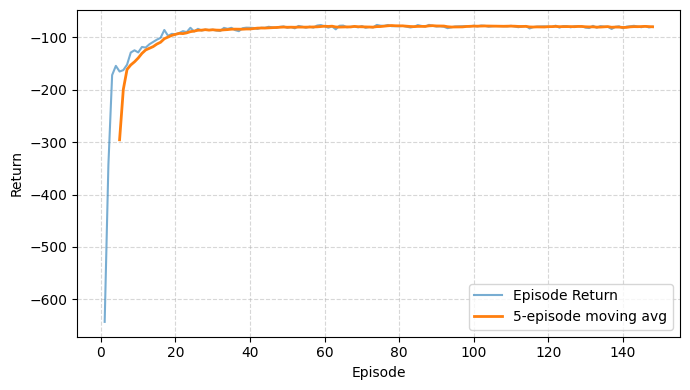

In [11]:
# -------------------------------------------------------------
# Plot: evolution of episode returns during training
# -------------------------------------------------------------
if len(ep_returns_sac) > 0:
    episodes = np.arange(1, len(ep_returns_sac) + 1)

    plt.figure(figsize=(7, 4))
    plt.plot(episodes, ep_returns_sac, label="Episode Return", alpha=0.6)

    # moving average
    window = 5
    if len(ep_returns_sac) >= window:
        ma = np.convolve(ep_returns_sac, np.ones(window) / window, mode="valid")
        plt.plot(
            np.arange(window, len(ep_returns_sac) + 1),
            ma,
            label=f"{window}-episode moving avg",
            linewidth=2,
        )

    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No episode returns were logged.")


Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.
Properties file weather station (G0800310) may be different from weather file used: c:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


Running RL Agent...
Running Baseline...


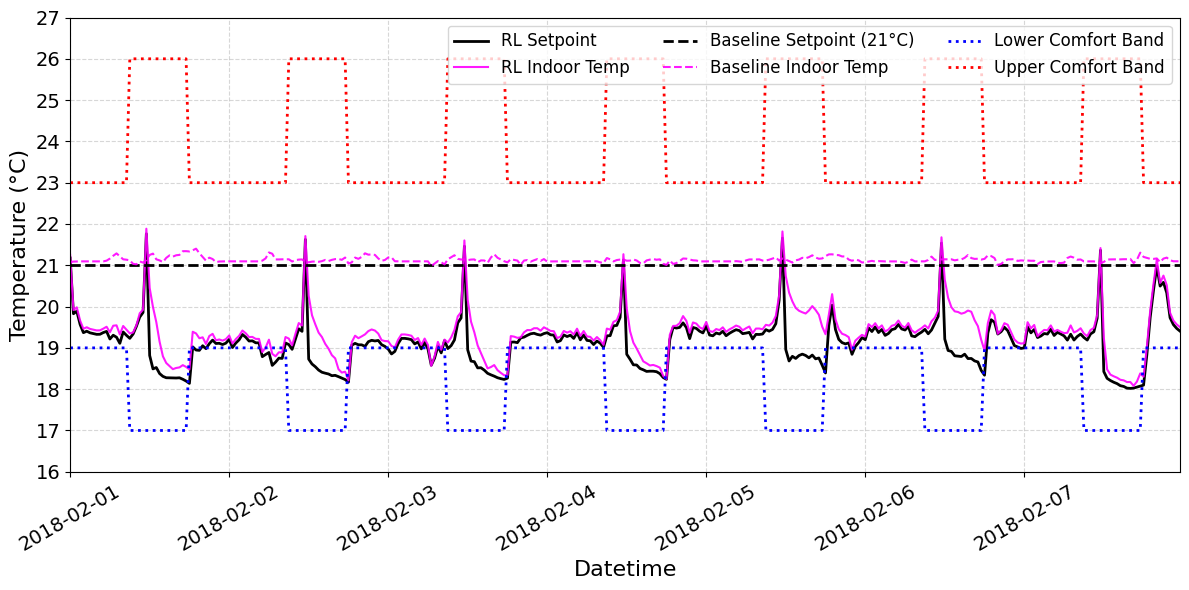

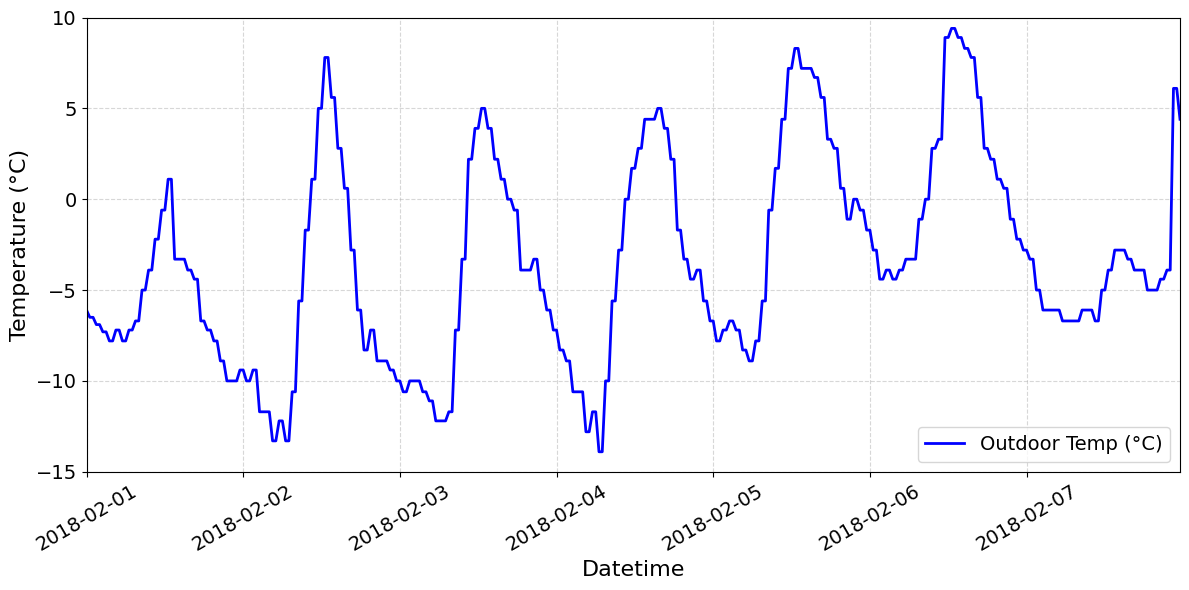

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===========================
# Helpers
# ===========================
def safe_datetime(info, t, start="2018-02-01", minutes=30):
    dt = info.get("Datetime", None) if isinstance(info, dict) else None
    if dt is None:
        return pd.Timestamp(start) + pd.Timedelta(minutes=minutes * t)
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)
    return dt

def extract_indoor_temp(obs, info):
    # Prefer info dict (ground truth from OCHRE)
    if isinstance(info, dict) and ("Temperature - Indoor (C)" in info):
        return float(info["Temperature - Indoor (C)"])
    # Fallback: base obs layout is [price, hour, T_in, T_out, ...]
    obs = np.asarray(obs).ravel()
    return float(obs[2]) if obs.size >= 3 else np.nan

def extract_outdoor_temp(obs, info):
    # Prefer info dict (ground truth from OCHRE)
    if isinstance(info, dict) and ("Temperature - Outdoor (C)" in info):
        return float(info["Temperature - Outdoor (C)"])
    # Fallback: base obs layout is [price, hour, T_in, T_out, ...]
    obs = np.asarray(obs).ravel()
    return float(obs[3]) if obs.size >= 4 else np.nan

def extract_obs_components(obs):
    """
    From the augmented obs vector:

    obs[0] = price_now
    obs[1] = hour_now
    obs[2] = T_in_now
    obs[3] = T_out_now
    obs[4:] = future T_out, future prices ...
    """
    obs = np.asarray(obs).ravel()
    price = float(obs[0]) if obs.size >= 1 else np.nan
    hour  = float(obs[1]) if obs.size >= 2 else np.nan
    tin   = float(obs[2]) if obs.size >= 3 else np.nan
    tout  = float(obs[3]) if obs.size >= 4 else np.nan
    return tin, tout, price, hour

# ---- same band logic as training wrapper ----
def compute_comfort_bands(hours):
    """
    Given an array of hour-of-day values, return arrays (low, high) using:

    - 19–23 °C between 18:00 and 09:00
    - 17–26 °C otherwise
    """
    hours = np.asarray(hours, dtype=float) % 24.0
    night_mask = (hours >= 18.0) | (hours < 9.0)

    lows  = np.where(night_mask, 19.0, 17.0)
    highs = np.where(night_mask, 23.0, 26.0)
    return lows, highs

# Derive hour-of-day from Datetime instead of rl_df["Hour"]
def compute_comfort_bands_from_datetime(datetimes):
    dt = pd.to_datetime(datetimes)
    hours = dt.dt.hour + dt.dt.minute / 60.0
    return compute_comfort_bands(hours)

# ===========================
# Baseline Controller
# ===========================
class RealisticThermostat:
    def __init__(self, setpoint=21):
        self.setpoint = np.array([setpoint], dtype=np.float32)

    def predict(self, obs, deterministic=True):
        # Ignores obs, always returns fixed setpoint
        return self.setpoint, None

# ===========================
# Evaluation Function
# ===========================
def evaluate_policy_with_actions(env, model, max_steps=2000):
    data = []
    obs, info = env.reset()

    for t in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        action = np.asarray(action, dtype=np.float32).ravel()
        if action.size == 0:
            raise RuntimeError("Empty action from model.")
        sp = float(action[0])

        obs, r, terminated, truncated, info = env.step(action)
        tin, tout, price, hour = extract_obs_components(obs)

        data.append({
            "Datetime": safe_datetime(info, t),
            "Setpoint_RL": sp,
            "IndoorTemp_RL": extract_indoor_temp(obs, info),
            "OutdoorTemp_RL": extract_outdoor_temp(obs, info),
            "Tout": tout,
            "Price": price,
            "Hour": hour,  # keep for debugging if you like
        })

        if terminated or truncated:
            break

        # obs from this step will be used next iteration

    return pd.DataFrame(data)

# ===========================
# Evaluation Env (same stack as training)
# ===========================
def make_eval_env():
    start_time = "2018-02-01 00:00:00"
    episode_duration = "7 days"

    base = make_env(start_time, episode_duration)
    base = VariableComfortRewardWrapper(
        base,
        comfort_unit_penalty=1.0,
        reward_scale=0.1,
    )
    base = ForecastObsWrapper(
        base,
        start_time=start_time,
        episode_duration=episode_duration,
        horizon_hours=12.0,
        time_res_minutes=30,
    )
    return base

env_feb = make_eval_env()

# ===========================
# Run Simulations
# ===========================
print("Running RL Agent...")
env_feb.reset()
rl_df = evaluate_policy_with_actions(env_feb, sac_model)

print("Running Baseline...")
env_feb.reset()
baseline_model = RealisticThermostat(setpoint=21)
base_df = evaluate_policy_with_actions(env_feb, baseline_model)

# Compute time-varying comfort bands based on Datetime (true clock time)
comfort_low_series, comfort_high_series = compute_comfort_bands_from_datetime(
    rl_df["Datetime"]
)

# ===========================
# Figure 1: Indoor Temperature Comparison
# ===========================
plt.figure(figsize=(12, 6))

# RL Plots (Solid)
plt.plot(rl_df["Datetime"], rl_df["Setpoint_RL"], color="black", linestyle="-", linewidth=2, label="RL Setpoint")
plt.plot(rl_df["Datetime"], rl_df["IndoorTemp_RL"], color="magenta", linestyle="-", alpha=0.9, linewidth=1.5, label="RL Indoor Temp")

# Baseline Plots (Dashed)
plt.plot(base_df["Datetime"], base_df["Setpoint_RL"], color="black", linestyle="--", linewidth=2, label="Baseline Setpoint (21°C)")
plt.plot(base_df["Datetime"], base_df["IndoorTemp_RL"], color="magenta", linestyle="--", alpha=0.9, linewidth=1.5, label="Baseline Indoor Temp")

# Time-varying Comfort Bands
plt.plot(rl_df["Datetime"], comfort_low_series,  color="blue", linestyle=":", linewidth=2, label="Lower Comfort Band")
plt.plot(rl_df["Datetime"], comfort_high_series, color="red",  linestyle=":", linewidth=2, label="Upper Comfort Band")

plt.xlabel("Datetime", fontsize=16)
plt.ylabel("Temperature (°C)", fontsize=16)
plt.ylim(16, 27)
plt.yticks(np.arange(16, 28, 1), fontsize=14)
plt.xlim(rl_df["Datetime"].min(), rl_df["Datetime"].max())
plt.legend(loc='upper right', ncol=3, fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=30, fontsize=14)
plt.tight_layout()
plt.show()

# ===========================
# Figure 2: Outdoor Temperature
# ===========================
plt.figure(figsize=(12, 6))
plt.plot(rl_df["Datetime"], rl_df["OutdoorTemp_RL"], color="blue", linewidth=2, label="Outdoor Temp (°C)")

plt.xlabel("Datetime", fontsize=16)
plt.ylabel("Temperature (°C)", fontsize=16)
plt.xlim(rl_df["Datetime"].min(), rl_df["Datetime"].max())
plt.ylim(-15, 10)
plt.yticks(np.arange(-15, 11, 5))
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=30, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


In [13]:
# Print the full action space object
print("Action Space:", env.action_space)

# Print the specific minimum and maximum values
print("Minimum Allowed Setpoint:", env.action_space.low)
print("Maximum Allowed Setpoint:", env.action_space.high)

Action Space: Box(18.0, 35.0, (1,), float32)
Minimum Allowed Setpoint: [18.]
Maximum Allowed Setpoint: [35.]
